In [46]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import confusion_matrix, classification_report,accuracy_score,f1_score,roc_auc_score, average_precision_score

from sklearn.compose import ColumnTransformer


In [47]:
import warnings
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")

In [48]:
df=pd.read_csv("AIML Dataset.csv")
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


## *Exploratory Data Analysis*

In [50]:
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

In [51]:
df['isFraud'].value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

In [52]:
df['isFlaggedFraud'].value_counts()

isFlaggedFraud
0    6362604
1         16
Name: count, dtype: int64

In [53]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [54]:
df.shape

(6362620, 11)

In [55]:
round((df["isFraud"].value_counts()[1]/df.shape[0])*100,2)

np.float64(0.13)

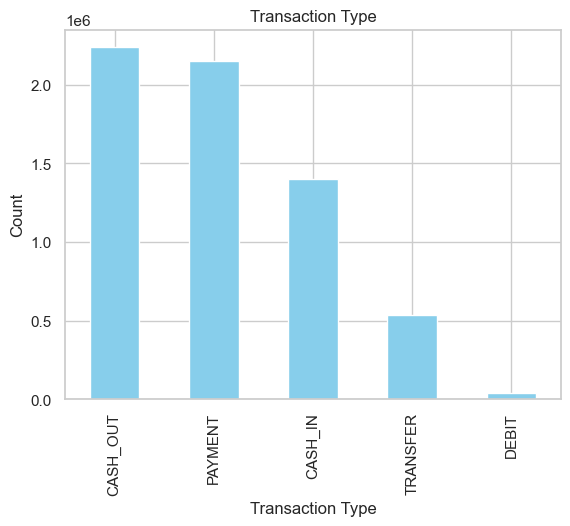

In [56]:
df["type"].value_counts().plot(kind="bar",
                               title="Transaction Type",
                               color="skyblue")
plt.xlabel("Transaction Type")
plt.ylabel("Count")
plt.show()

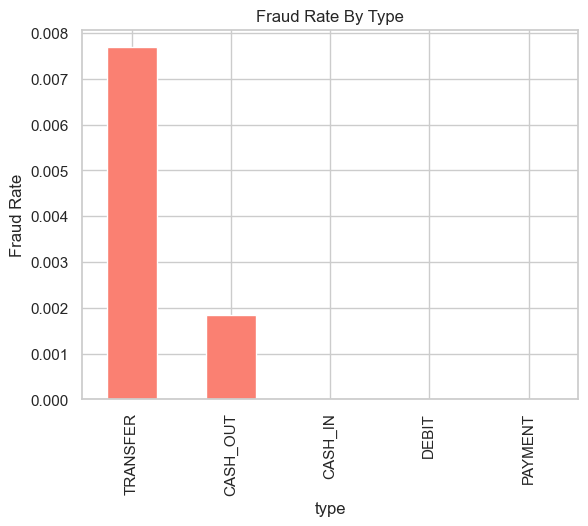

In [57]:
fraud_by_type=df.groupby("type")["isFraud"].mean().sort_values(ascending=False)
fraud_by_type.plot(kind="bar",title="Fraud Rate By Type",color="salmon")
plt.ylabel("Fraud Rate")
plt.show()

In [58]:
fraud_by_type

type
TRANSFER    0.007688
CASH_OUT    0.001840
CASH_IN     0.000000
DEBIT       0.000000
PAYMENT     0.000000
Name: isFraud, dtype: float64

In [59]:
df["amount"].describe().astype(int)

count     6362620
mean       179861
std        603858
min             0
25%         13389
50%         74871
75%        208721
max      92445516
Name: amount, dtype: int64

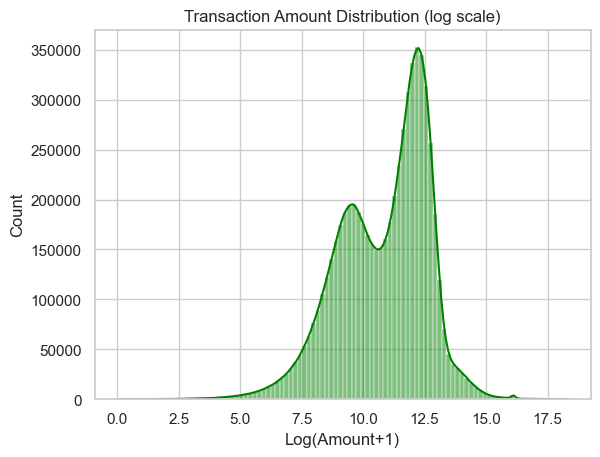

In [60]:
sns.histplot(np.log1p(df["amount"]),bins=100,kde=True,color="green")
plt.title("Transaction Amount Distribution (log scale)")
plt.xlabel("Log(Amount+1)")
plt.show()

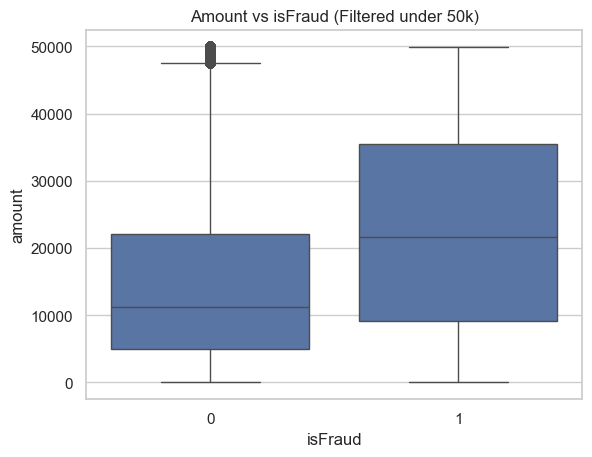

In [61]:
sns.boxplot(data=df[df["amount"]<50000],x="isFraud",y="amount")
plt.title("Amount vs isFraud (Filtered under 50k)")
plt.show()

In [62]:
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

## *Feature Engineering*

In [63]:
df["balanceDiffOrig"]=df['oldbalanceOrg']-df['newbalanceOrig']
df["balanceDiffDest"]=df['newbalanceDest']-df['oldbalanceDest']

In [64]:
(df["balanceDiffOrig"]<0).sum()

np.int64(1399253)

In [65]:
(df["balanceDiffDest"]<0).sum()

np.int64(1238864)

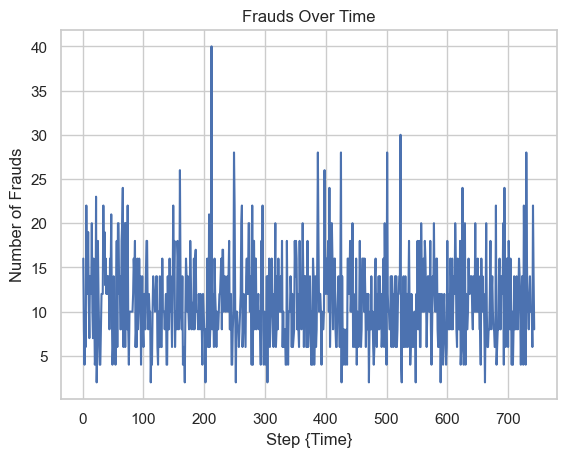

In [66]:
frauds_per_step=df[df["isFraud"]==1]["step"].value_counts().sort_index()
plt.plot(frauds_per_step.index,frauds_per_step.values,label="Frauds per Step")
plt.xlabel("Step {Time}")
plt.ylabel("Number of Frauds")
plt.title("Frauds Over Time")
plt.grid(True)
plt.show()

In [67]:
df.drop(columns="step",inplace=True)

In [68]:
top_senders=df["nameOrig"].value_counts().head(10)

In [69]:
top_senders

nameOrig
C1677795071    3
C1999539787    3
C724452879     3
C1976208114    3
C400299098     3
C1784010646    3
C1530544995    3
C1065307291    3
C545315117     3
C1902386530    3
Name: count, dtype: int64

In [70]:
top_senders=df["nameOrig"].value_counts()

In [71]:
top_receivers=df["nameDest"].value_counts().head(10)

In [72]:
top_receivers

nameDest
C1286084959    113
C985934102     109
C665576141     105
C2083562754    102
C248609774     101
C1590550415    101
C1789550256     99
C451111351      99
C1360767589     98
C1023714065     97
Name: count, dtype: int64

In [73]:
fraud_users=df[df["isFraud"]==1]["nameOrig"].value_counts().head(10)
fraud_users

nameOrig
C1280323807    1
C1305486145    1
C840083671     1
C1420196421    1
C2101527076    1
C1039979813    1
C2089752665    1
C1614818636    1
C40604503      1
C1970706589    1
Name: count, dtype: int64

In [74]:
fraud_types=df[df["type"].isin(["TRANSFER","CASH_OUT"])]


In [75]:
fraud_types["type"].value_counts()

type
CASH_OUT    2237500
TRANSFER     532909
Name: count, dtype: int64

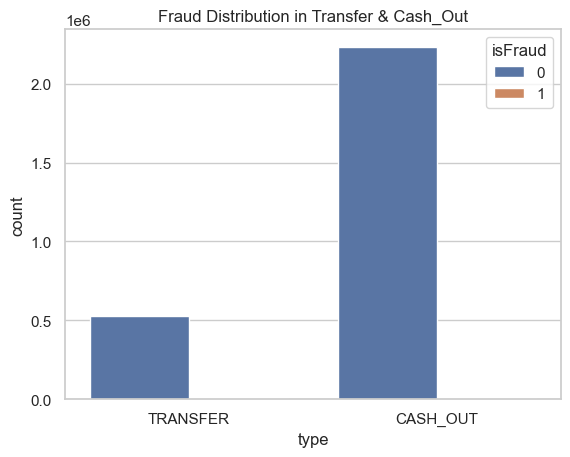

In [76]:
sns.countplot(data=fraud_types,x="type",hue="isFraud")
plt.title("Fraud Distribution in Transfer & Cash_Out")
plt.show()

In [77]:
corr=df[['amount','oldbalanceOrg', 'newbalanceOrig','oldbalanceDest', 'newbalanceDest','isFraud']].corr()
corr

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
amount,1.000000,-0.002762,-0.007861,0.294137,0.459304,0.076688
oldbalanceOrg,-0.002762,1.000000,0.998803,0.066243,0.042029,0.010154
newbalanceOrig,-0.007861,0.998803,1.000000,0.067812,0.041837,-0.008148
oldbalanceDest,0.294137,0.066243,0.067812,1.000000,0.976569,-0.005885
newbalanceDest,0.459304,0.042029,0.041837,0.976569,1.000000,0.000535
isFraud,0.076688,0.010154,-0.008148,-0.005885,0.000535,1.000000


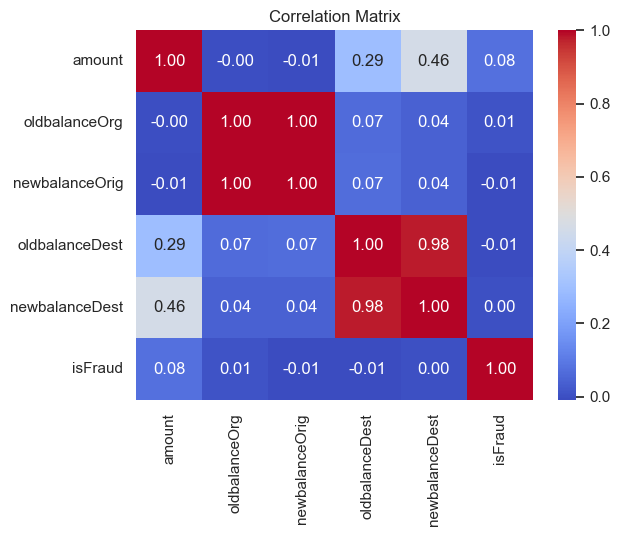

In [78]:
sns.heatmap(corr,annot=True,cmap="coolwarm",fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [79]:
zero_after_transfer=df[
    (df["oldbalanceOrg"]>0) &
    (df["newbalanceOrig"]==0) &
    (df["type"].isin(["TRANSFER","CASH_OUT"]))
]

In [80]:
len(zero_after_transfer)

1188074

In [81]:
zero_after_transfer.head()

,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,balanceDiffOrig,balanceDiffDest
2,TRANSFER,181.00,C1305486145,181.0,0.0,C553264065,0.0,0.00,1,0,181.0,0.00
3,CASH_OUT,181.00,C840083671,181.0,0.0,C38997010,21182.0,0.00,1,0,181.0,-21182.00
15,CASH_OUT,229133.94,C905080434,15325.0,0.0,C476402209,5083.0,51513.44,0,0,15325.0,46430.44
19,TRANSFER,215310.30,C1670993182,705.0,0.0,C1100439041,22425.0,0.00,0,0,705.0,-22425.00
24,TRANSFER,311685.89,C1984094095,10835.0,0.0,C932583850,6267.0,2719172.89,0,0,10835.0,2712905.89


In [82]:
df["isFraud"].value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

In [83]:
df.head()

,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,balanceDiffOrig,balanceDiffDest
0,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,9839.64,0.0
1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,1864.28,0.0
2,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,181.00,0.0
3,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,181.00,-21182.0
4,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,11668.14,0.0


In [84]:
df_model=df.drop(["nameOrig","nameDest","isFlaggedFraud"],axis=1)

In [85]:
df_model.head()

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,balanceDiffOrig,balanceDiffDest
0,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0,9839.64,0.0
1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0,1864.28,0.0
2,TRANSFER,181.00,181.0,0.00,0.0,0.0,1,181.00,0.0
3,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1,181.00,-21182.0
4,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0,11668.14,0.0


In [86]:
categorical=["type"]

numeric = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest','balanceDiffOrig', 'balanceDiffDest']

In [87]:
y=df_model["isFraud"]
X=df_model.drop("isFraud",axis=1)

## *Train-Validation-Test Split*
Using a 3-way split to prevent data leakage during threshold tuning.

In [88]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

In [89]:
preprocessor=ColumnTransformer(
    transformers=[
        ("num",StandardScaler(),numeric),
        ("cat",OneHotEncoder(drop="first",handle_unknown="ignore"),categorical)

    ],remainder="drop"
)

## *Baseline Model*

In [90]:
pipeline=Pipeline([
    ("prep",preprocessor),
    ("clf",LogisticRegression(class_weight="balanced",max_iter=1000))
])

In [91]:
pipeline.fit(X_train,y_train)

,steps,"[('prep', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [92]:
y_pred=pipeline.predict(X_val)

In [93]:
print(classification_report(y_val,y_pred))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97    953161
           1       0.02      0.94      0.04      1232

    accuracy                           0.95    954393
   macro avg       0.51      0.94      0.51    954393
weighted avg       1.00      0.95      0.97    954393



In [94]:
confusion_matrix(y_val,y_pred)

array([[902852,  50309],
       [    72,   1160]])

## *Random Forest*

In [95]:
rf_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(
        n_estimators=50,     
        max_depth=10,        
        n_jobs=-1,           
        class_weight="balanced",
        random_state=42
    ))
])

In [96]:
rf_model.fit(X_train,y_train)

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [97]:
y_pred_rf=rf_model.predict(X_val)
y_prob = rf_model.predict_proba(X_val)[:, 1]


In [98]:
accuracy_score(y_val, y_pred_rf)

0.9913169941523041

In [99]:
print("Confusion Matrix :\n",confusion_matrix(y_val,y_pred_rf))

Confusion Matrix :
 [[944892   8269]
 [    18   1214]]


In [100]:
print(classification_report(y_val, y_pred_rf))

roc_auc = roc_auc_score(y_val, y_prob)
pr_auc = average_precision_score(y_val, y_prob)

print(f"ROC-AUC: {roc_auc:.4f}")
print(f"PR-AUC: {pr_auc:.4f}")


              precision    recall  f1-score   support

           0       1.00      0.99      1.00    953161
           1       0.13      0.99      0.23      1232

    accuracy                           0.99    954393
   macro avg       0.56      0.99      0.61    954393
weighted avg       1.00      0.99      0.99    954393

ROC-AUC: 0.9989
PR-AUC: 0.9041


## *Threshold Optimization*

In [101]:
def find_best_threshold(y_true, y_prob):
    best_f1 = 0
    best_t = 0.5
    
    for t in np.arange(0.1, 1.0, 0.01):
        y_pred = (y_prob >= t).astype(int)
        f1 = f1_score(y_true, y_pred)
        
        if f1 > best_f1:
            best_f1 = f1
            best_t = t
    
    return best_t, best_f1

best_t, best_f1 = find_best_threshold(y_val, y_prob)

print(f"Best Threshold: {best_t}")
print(f"Best F1: {best_f1:.4f}")


Best Threshold: 0.9699999999999995
Best F1: 0.8376


## *Model Evaluation*

In [102]:
# Model Evaluation (Using Tuned Threshold)
y_test_prob = rf_model.predict_proba(X_test)[:, 1]

y_pred_final = (y_test_prob >= best_t).astype(int)
print(classification_report(y_test, y_pred_final))



              precision    recall  f1-score   support

           0       1.00      1.00      1.00    953161
           1       0.94      0.74      0.82      1232

    accuracy                           1.00    954393
   macro avg       0.97      0.87      0.91    954393
weighted avg       1.00      1.00      1.00    954393



## *Risk-Based Categorization System*


In [103]:
def classify_risk(prob):
    if prob >= best_t:
        return "Fraud"
    elif prob >= 0.75:
        return "High Risk"
    else:
        return "Low Risk"

risk_labels = [classify_risk(p) for p in y_test_prob]

import pandas as pd
risk_distribution = pd.Series(risk_labels).value_counts()

print("Risk Category Distribution:")
print(risk_distribution)


Risk Category Distribution:
Low Risk     950017
High Risk      3411
Fraud           965
Name: count, dtype: int64


In [104]:
import joblib

joblib.dump({
    "model": rf_model,
    "threshold": best_t
}, "fraud_model_detection.pkl")



['fraud_model_detection.pkl']